In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


## Exploring fake news

In [5]:
fake = pd.read_csv("https://raw.githubusercontent.com/Shrawan78/Applied-Machine-Learning/refs/heads/main/Dataset/Fake.csv")

In [6]:
fake = fake.sample(n=21417, random_state=42)
fake.shape

(21417, 4)

In [7]:
fake.head()

,title,text,subject,date
13474,ABOUT HILLARY’S COUGH: We Discovered The Secre...,,politics,"Jul 20, 2016"
11994,BREAKING: OBAMACARE REPEAL Clears First Hurdle...,The Senate voted 51-48 this afternoon to proce...,politics,"Jan 4, 2017"
19179,‘SLEEPY’ JUSTICE GINSBURG: Excites Crowd By Sa...,So much for the SCOTUS not being political Che...,left-news,"Feb 7, 2017"
501,WATCH: Kellyanne Conway Very Upset Hillary Cl...,White House counselor Kellyanne Conway crawled...,News,"August 24, 2017"
3492,"GOP Gives Trump The Middle Finger, Prepares T...",Donald Trump may have decided that Russia is g...,News,"December 9, 2016"


In [8]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [9]:
fake["subject"].value_counts()

,count
subject,
News,8241
politics,6259
left-news,4074
Government News,1433
US_News,708
Middle-east,702


<Axes: xlabel='subject', ylabel='count'>

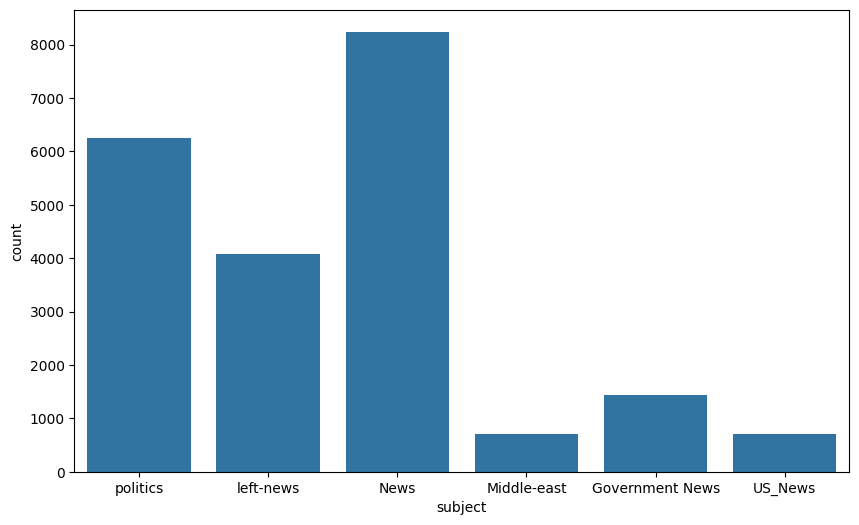

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(x= "subject",data=fake)

## Wordcloud

In [11]:
# Joining all the text Data
text = " ".join(fake["text"].tolist())

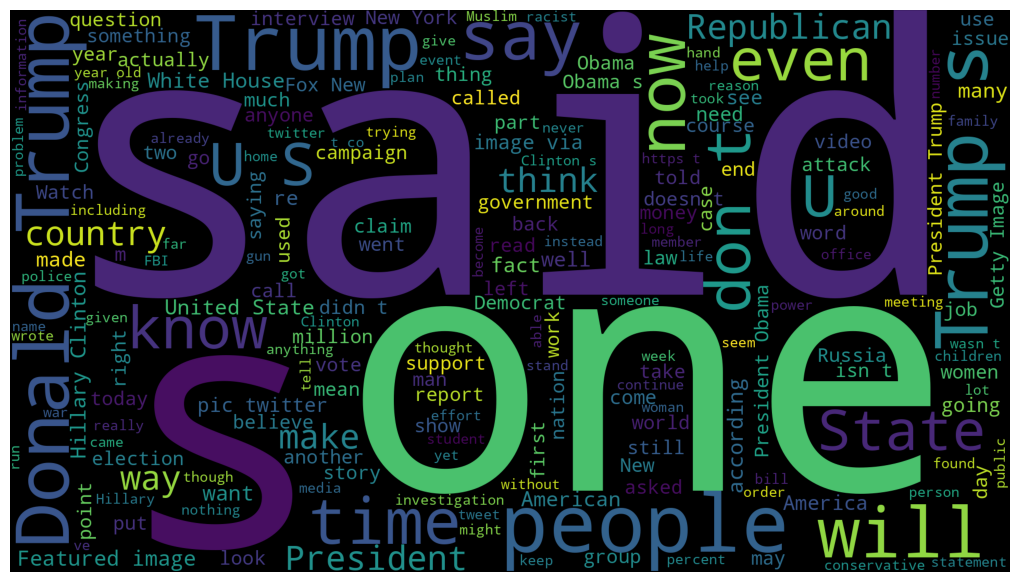

In [12]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Exploring Real news

In [13]:
real = pd.read_csv("https://raw.githubusercontent.com/Shrawan78/Applied-Machine-Learning/refs/heads/main/Dataset/True.csv")

In [14]:
real.shape

(21417, 4)

In [15]:
# Joining all the text Data
text = " ".join(real["text"].tolist())

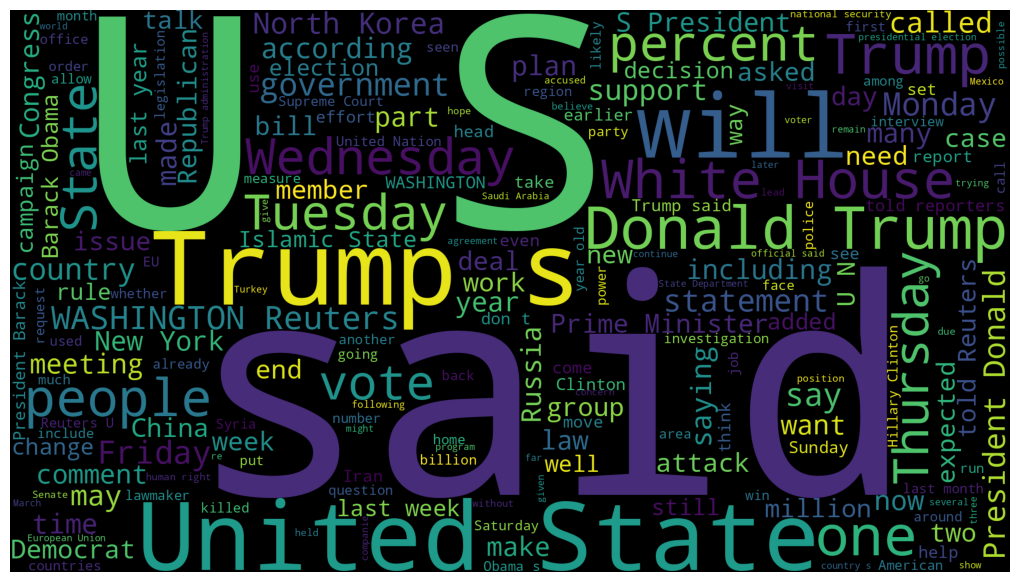

In [16]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [17]:
real.sample(5)

,title,text,subject,date
5708,Trump vows to end prohibition on church politi...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"February 3, 2017"
9143,Trump to meet with House Republicans on July 7,WASHINGTON (Reuters) - Donald Trump will speak...,politicsNews,"June 14, 2016"
13646,UK says seeking to build on 'momentum' for Bre...,LONDON (Reuters) - Britain is seeking to build...,worldnews,"November 28, 2017"
4156,U.S. Treasury's Mnuchin says will unveil tax r...,WASHINGTON (Reuters) - The Trump administratio...,politicsNews,"April 20, 2017"
7884,Trump's body language during debate raises soc...,NEW YORK (Reuters) - U.S. Republican presiden...,politicsNews,"October 10, 2016"


In [18]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
  try:
    record = row.split("-", maxsplit=1)
    record[1]
    assert(len(record[0])<120)
  except:
    unknown_publishers.append(index)


In [19]:
len(unknown_publishers)

222

In [20]:
real.iloc[unknown_publishers].text

,text
7,The following statements were posted to the ve...
8,The following statements were posted to the ve...
12,The following statements were posted to the ve...
13,The following statements were posted to the ve...
14,"(In Dec. 25 story, in second paragraph, corre..."
...,...
20135,(Story corrects to million from billion in pa...
20500,"(This Sept 8 story corrects headline, clarifi..."
20667,"(Story refiles to add dropped word not , in ..."
21246,(Story corrects third paragraph to show Mosul...


In [21]:
#8970 is empty so we need to drop it
real.iloc[8970]

,8970
title,Graphic: Supreme Court roundup
text,
subject,politicsNews
date,"June 16, 2016"


In [22]:
real = real.drop(8970, axis=0)

In [23]:
publisher = []
temp_text = []

for index, row in enumerate(real.text.values):
  if index in unknown_publishers:
    temp_text.append(row)
    publisher.append("Unknown")
    continue
  else:
    record = row.split("-",maxsplit=1)
    publisher.append(record[0].strip())
    temp_text.append(record[1].strip())

In [24]:
real["publisher"] = publisher
real["text"] = temp_text

In [25]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [26]:
real.shape

(21416, 5)

In [27]:
empty_fake_index = [index for index,text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [28]:
fake.iloc[empty_fake_index]

,title,text,subject,date
13474,ABOUT HILLARY’S COUGH: We Discovered The Secre...,,politics,"Jul 20, 2016"
13037,BREAKING: MYSTERIOUS METAL OBJECT Flings Out O...,,politics,"Sep 11, 2016"
12025,BOOM! TOMI LAHREN’S Top Tips For Liberals In 2...,,politics,"Dec 31, 2016"
16273,WIKILEAKS HITS BACK At Lying Political Hack Ja...,,Government News,"Jan 5, 2017"
11686,JESSE WATTERS Takes On Young Anti-Trump Protes...,,politics,"Feb 11, 2017"
...,...,...,...,...
11421,Young “TRUMP GIRL” Will Blow You Away: “We’re ...,,politics,"Mar 13, 2017"
16336,A VOTE FOR HILLARY IS A VOTE FOR WW III: Are Y...,,Government News,"Oct 28, 2016"
11371,SHARE THIS EVERYWHERE! DISEASED REFUGEES Get S...,,politics,"Mar 18, 2017"
15710,(VIDEO) KRAUTHAMMER: FORMER CIA DEPUTY DIRECTO...,,politics,"May 12, 2015"


In [29]:
real["text"] = real["title"] + " " + real["text"]
fake["text"] = fake["title"] + " " + fake["text"]

## Converting to lowercase

In [30]:
real["text"] = real["text"].apply(lambda x: str(x).lower())
fake["text"] = fake["text"].apply(lambda x: str(x).lower())

# Performing Text Preprocessing

In [31]:
real["class"] = 1
fake["class"] = 0

In [32]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [33]:
real = real[["text","class"]]
fake = fake[["text","class"]]

In [34]:
data = pd.concat([real, fake], ignore_index=True)

In [35]:
data.sample(5)

,text,class
10827,indian-american judge who could replace scalia...,1
29527,how diplomatic! senator mccain responds to cri...,0
25598,sharia compliant swimsuits: as spring arrives ...,0
22285,smoking gun? first fisa request on trump tower...,0
6014,factbox: 70 years of the 'special relationship...,1


In [ ]:
# Here we are using kgptalkie which is not a built-in function in python or pandas.
# Link for it - https://github.com/Shrawan78/preprocess_kgptalkie
# We will install the required dependencies.

In [ ]:
!pip install spacy==3.7.6
!python -m spacy download en_core_web_sm
!pip install nltk==3.9.1
!pip install beautifulsoup4
!pip install textblob==0.18.0.post0
!pip install googletrans==3.1.0a0
!pip install gensim
!pip install preprocess-kgptalkie --upgrade

In [39]:
import preprocess_kgptalkie as ps

In [40]:
data["text"].head(5)

,text
0,"as u.s. budget fight looms, republicans flip t..."
1,u.s. military to accept transgender recruits o...
2,senior u.s. republican senator: 'let mr. muell...
3,fbi russia probe helped by australian diplomat...
4,trump wants postal service to charge 'much mor...


In [41]:
# Removing all the special characters
data["text"] = data["text"].apply(lambda x: ps.remove_special_chars(x))

In [42]:
data["text"].head(5)

,text
0,as us budget fight looms republicans flip thei...
1,us military to accept transgender recruits on ...
2,senior us republican senator let mr mueller do...
3,fbi russia probe helped by australian diplomat...
4,trump wants postal service to charge much more...


## Vectorization Process

In [83]:
import gensim
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report)

In [46]:
# y is our target
y = data["class"].values

In [47]:
text_data = data["text"].tolist()  # Save original text for SVM model

In [48]:
#We are converting all the text data into list of lists by using list comprehension method
x = [d.split() for d in data["text"].tolist()]

In [49]:
type(x[0])

list

In [50]:
#Now we need to feed this x into our gensim model word to vector conversion
DIM = 100 #Using 100 dimension of the data. It means each of these words will be converted into sequence of 100 vectors
w2v_model = gensim.models.Word2Vec(sentences=x, vector_size=DIM, window=10, min_count = 1)

In [51]:
w2v_model.wv["china"]

array([-5.2546134 ,  3.5786567 , -0.41191924,  4.087681  , -0.49373093,
        2.734824  ,  2.8608525 ,  1.0956078 , -4.2250357 ,  1.292078  ,
        2.2744868 , -0.40558618, -1.2439586 , -4.1484075 , -0.20257017,
        2.0448866 ,  1.2123798 ,  4.0518556 ,  0.46187553, -0.29552543,
        1.8265425 ,  4.2742863 , -1.1383685 , -2.188272  , -2.6718016 ,
       -0.891632  , -5.69848   , -5.0610037 , -0.8072229 , -0.12835121,
        1.9862293 , -1.1741937 ,  2.630056  , -3.4021797 ,  0.86644834,
       -0.86800855, -1.8026805 ,  0.34579912, -1.3660176 ,  0.01170809,
        5.9219527 , -1.9995213 ,  5.5201654 ,  3.506761  , -2.7963762 ,
       -1.9779111 , -1.0076704 , -2.0045266 ,  1.5901053 , -1.6846529 ,
        2.993411  ,  0.5391543 ,  1.0696158 , -1.4158391 ,  0.88610715,
        2.7183237 ,  1.5398494 , -6.3074694 ,  1.9899853 , -2.9260511 ,
       -2.190596  ,  1.5981236 ,  1.4599379 , -0.2718116 ,  3.6371226 ,
        1.3757522 ,  1.3576882 , -2.14759   , -0.9669041 , -2.26

In [52]:
w2v_model.wv.most_similar("china") # We are getting most similar words using gensim

[('beijing', 0.8714342713356018),
 ('taiwan', 0.8367763757705688),
 ('chinas', 0.7635861039161682),
 ('chinese', 0.7174617052078247),
 ('taipei', 0.6832360029220581),
 ('pyongyang', 0.6703364849090576),
 ('beijings', 0.6627767086029053),
 ('japan', 0.654447615146637),
 ('waterway', 0.6499560475349426),
 ('xi', 0.6460838913917542)]

##### Now we have two methods to train our models, one is that we can directly use these vectors and another method is to feed these vectors as a intial weight in our machine learning model then the ml model recreates these vectors.


In [53]:
# The result was found that if we feed these vectors as intial weight, this will result in higher accuracy.

In [54]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

In [55]:
x = tokenizer.texts_to_sequences(x)

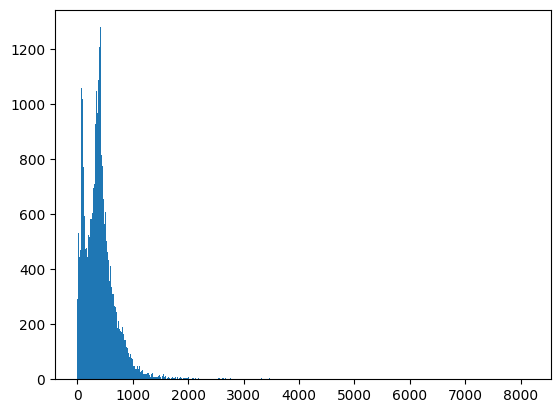

In [56]:
# Analyzing our text data which we currently have in x
plt.hist([len(i) for i in x], bins = 700)
plt.show()
# This will show us histogram of the total number of words present in our news

# We can see that mostly the words are less than 1000. We will truncate the news which have more than 1000 words.

In [57]:
nos = np.array([len(i) for i in x])
len(nos[nos > 1000]) #Length of news which have more than 1000 words

1499

In [58]:
maxlen = 1000
x = pad_sequences(x, maxlen=maxlen)

In [59]:
len(x[56])

1000

In [60]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [61]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))

  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [62]:
embedding_vectors = get_weight_matrix(w2v_model)

In [63]:
embedding_vectors.shape

(222336, 100)

In [64]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
# Trainable is false because the model is not going to retrain those vectors
# we can put true as well instead of false. we can try and test whichever works best for us.
# In machine learning algorithm there is no fundamental rule to define these things

model.add(LSTM(units=128))
model.add(Dense(1, activation = "sigmoid"))
# We have used sigmoid as we have only two classes 0 and 1. Otherwise we need to use softmax (Multi-class Classification).
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["acc"])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [65]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    22,233,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,233,600 (84.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 22,233,600 (84.81 MB)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
X_train_text, X_test_text, y_train_svm, y_test_svm = train_test_split(text_data, y, test_size=0.25, random_state=42)

In [67]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
703/703 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - acc: 0.9147 - loss: 0.2118 - val_acc: 0.9668 - val_loss: 0.0887
Epoch 2/6
703/703 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - acc: 0.9743 - loss: 0.0755 - val_acc: 0.9860 - val_loss: 0.0436
Epoch 3/6
703/703 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - acc: 0.9891 - loss: 0.0338 - val_acc: 0.9726 - val_loss: 0.0778
Epoch 4/6
703/703 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - acc: 0.9856 - loss: 0.0418 - val_acc: 0.9912 - val_loss: 0.0279
Epoch 5/6
703/703 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - acc: 0.9912 - loss: 0.0275 - val_acc: 0.9923 - val_loss: 0.0231
Epoch 6/6
703/703 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - acc: 0.9972 - loss: 0.0098 - val_acc: 0.9902 - val_loss: 0.0278


In [68]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

335/335 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


In [69]:
accuracy_score(y_test, y_pred)

0.9887944719394901

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5310
           1       0.99      0.99      0.99      5399

    accuracy                           0.99     10709
   macro avg       0.99      0.99      0.99     10709
weighted avg       0.99      0.99      0.99     10709



In [71]:
input_text = ["this is a news"]
input_text = tokenizer.texts_to_sequences(input_text)
input_text = pad_sequences(input_text, maxlen=maxlen)

In [72]:
model.predict(input_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([[0.02893102]], dtype=float32)

In [73]:
(model.predict(input_text) >=0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


array([[0]])

In [74]:
#For SVM
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=2000,
        ngram_range=(1, 1),
        max_df=0.85,
        min_df=2
    )),
    ('svm', LinearSVC(
        C=1.0,
        random_state=42,
        max_iter=2000,
        dual=True,
        verbose=1
    ))
])

In [75]:
# Train SVM
svm_pipeline.fit(X_train_text, y_train)
y_pred_svm = svm_pipeline.predict(X_test_text)

[LibLinear]

In [76]:
# PERFORMANCE COMPARISON
print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)

# LSTM Metrics
print("\nLSTM Results:")
lstm_acc = accuracy_score(y_test, y_pred)
lstm_prec = precision_score(y_test, y_pred)
lstm_rec = recall_score(y_test, y_pred)
lstm_f1 = f1_score(y_test, y_pred)

print(f"Accuracy:  {lstm_acc:.4f}")
print(f"Precision: {lstm_prec:.4f}")
print(f"Recall:    {lstm_rec:.4f}")
print(f"F1-Score:  {lstm_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# SVM Metrics
print("\nSVM Results:")
svm_acc = accuracy_score(y_test_svm, y_pred_svm)
svm_prec = precision_score(y_test_svm, y_pred_svm)
svm_rec = recall_score(y_test_svm, y_pred_svm)
svm_f1 = f1_score(y_test_svm, y_pred_svm)

print(f"Accuracy:  {svm_acc:.4f}")
print(f"Precision: {svm_prec:.4f}")
print(f"Recall:    {svm_rec:.4f}")
print(f"F1-Score:  {svm_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_svm, y_pred_svm, target_names=['Fake', 'Real']))


PERFORMANCE COMPARISON

LSTM Results:
Accuracy:  0.9888
Precision: 0.9891
Recall:    0.9887
F1-Score:  0.9889

Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      5310
        Real       0.99      0.99      0.99      5399

    accuracy                           0.99     10709
   macro avg       0.99      0.99      0.99     10709
weighted avg       0.99      0.99      0.99     10709


SVM Results:
Accuracy:  0.9886
Precision: 0.9871
Recall:    0.9904
F1-Score:  0.9887

Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      5310
        Real       0.99      0.99      0.99      5399

    accuracy                           0.99     10709
   macro avg       0.99      0.99      0.99     10709
weighted avg       0.99      0.99      0.99     10709



In [77]:
#COMPARISON TABLE
comparison_df = pd.DataFrame({
    'Model': ['LSTM', 'SVM'],
    'Accuracy': [lstm_acc, svm_acc],
    'Precision': [lstm_prec, svm_prec],
    'Recall': [lstm_rec, svm_rec],
    'F1-Score': [lstm_f1, svm_f1]
})

print("\n" + "="*50)
print("COMPARISON TABLE")
print("="*50)
print(comparison_df.to_string(index=False))


COMPARISON TABLE
Model  Accuracy  Precision   Recall  F1-Score
 LSTM  0.988794   0.989068 0.988702  0.988885
  SVM  0.988608   0.987078 0.990369  0.988720


Visualization

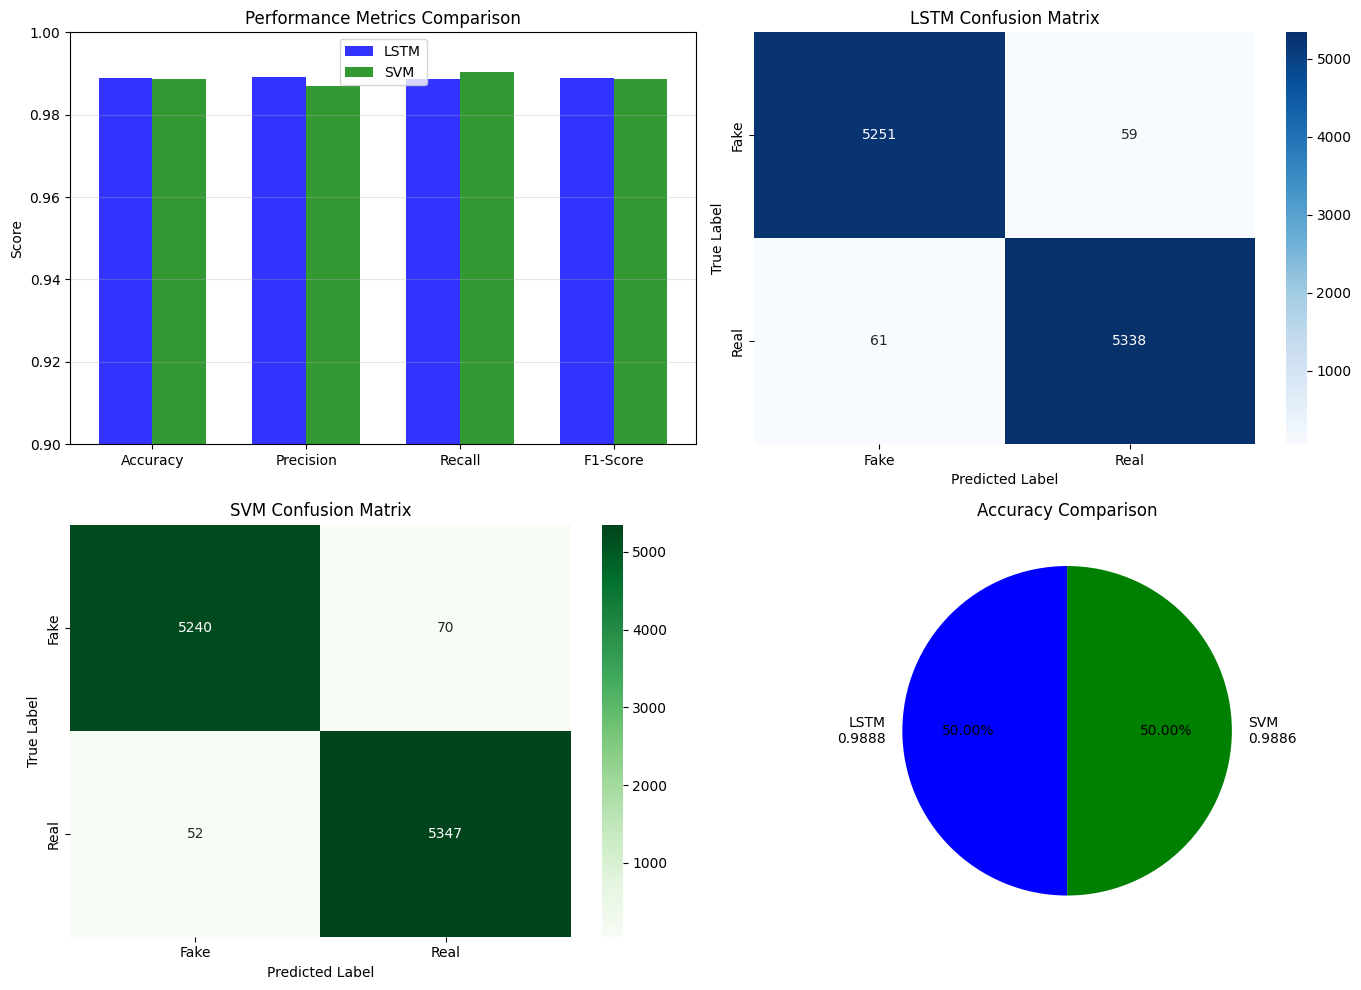

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Metrics comparison bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metrics))
lstm_scores = [lstm_acc, lstm_prec, lstm_rec, lstm_f1]
svm_scores = [svm_acc, svm_prec, svm_rec, svm_f1]

ax = axes[0, 0]
width = 0.35
ax.bar(x_pos - width/2, lstm_scores, width, label='LSTM', alpha=0.8, color='blue')
ax.bar(x_pos + width/2, svm_scores, width, label='SVM', alpha=0.8, color='green')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0.9, 1.0])
ax.grid(axis='y', alpha=0.3)

# 2. LSTM Confusion Matrix
ax = axes[0, 1]
cm_lstm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('LSTM Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(['Fake', 'Real'])
ax.set_yticklabels(['Fake', 'Real'])

# 3. SVM Confusion Matrix
ax = axes[1, 0]
cm_svm = confusion_matrix(y_test_svm, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', ax=ax)
ax.set_title('SVM Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(['Fake', 'Real'])
ax.set_yticklabels(['Fake', 'Real'])

# 4. Model comparison pie chart
ax = axes[1, 1]
colors = ['blue', 'green']
sizes = [lstm_acc, svm_acc]
labels = [f'LSTM\n{lstm_acc:.4f}', f'SVM\n{svm_acc:.4f}']
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
ax.set_title('Accuracy Comparison')

plt.tight_layout()
plt.savefig('lstm_vs_svm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [79]:
fake_news_examples = [
    "Breaking: Scientists discover that drinking bleach cures all diseases including cancer",
    "SHOCKING: Bill Gates admits to putting microchips in vaccines to control population",
    "World leaders secretly meeting on Mars to plan alien invasion of Earth next month",
    "Doctors reveal that 5G towers are causing coronavirus spread across the world",
    "President announces free money for everyone who shares this post on social media",
    "New study shows eating pizza every day makes you lose weight faster than exercise",
    "URGENT: Government planning to ban all cars and force everyone to walk everywhere",
    "Celebrity caught on camera shapeshifting into reptilian alien form in public",
    "Miracle cure discovered: this one weird trick eliminates all health problems forever",
    "Breaking news: Moon landing was filmed in Hollywood studio director confesses"
]

real_news_examples = [
    "The Federal Reserve announced today that interest rates will remain unchanged following the latest economic review",
    "NASA's James Webb Space Telescope captures stunning images of distant galaxy formations",
    "Stock markets showed mixed results today with technology sector leading gains",
    "Climate scientists report continued warming trends in Arctic regions based on satellite data",
    "Congress passes bipartisan infrastructure bill after months of negotiations"
]

In [80]:
def test_news(text, label_type="TEST"):
    # Preprocess for LSTM
    text_clean = ps.remove_special_chars(text.lower())

    # LSTM prediction
    text_seq = tokenizer.texts_to_sequences([text_clean.split()])
    text_pad = pad_sequences(text_seq, maxlen=maxlen)
    lstm_pred = model.predict(text_pad, verbose=0)[0][0]
    lstm_class = "REAL" if lstm_pred >= 0.5 else "FAKE"

    # SVM prediction (no probability, just decision)
    svm_pred = svm_pipeline.predict([text])[0]
    svm_class = "REAL" if svm_pred == 1 else "FAKE"

    # Get decision function score (distance from hyperplane)
    svm_decision = svm_pipeline.decision_function([text])[0]
    svm_confidence = abs(svm_decision)  # Distance from decision boundary

    print(f"\n{label_type}:")
    print(f"Text: {text[:80]}...")
    print(f"LSTM: {lstm_class} (confidence: {lstm_pred:.4f})")
    print(f"SVM:  {svm_class} (decision score: {svm_decision:.4f})")
    print(f"Agreement: {'✓ YES' if lstm_class == svm_class else '✗ NO'}")

print("\n--- TESTING FAKE NEWS EXAMPLES ---")
for i, news in enumerate(fake_news_examples, 1):
    test_news(news, f"FAKE #{i}")

print("\n\n--- TESTING REAL NEWS EXAMPLES ---")
for i, news in enumerate(real_news_examples, 1):
    test_news(news, f"REAL #{i}")


--- TESTING FAKE NEWS EXAMPLES ---

FAKE #1:
Text: Breaking: Scientists discover that drinking bleach cures all diseases including ...
LSTM: REAL (confidence: 0.5099)
SVM:  FAKE (decision score: -3.7193)
Agreement: ✗ NO

FAKE #2:
Text: SHOCKING: Bill Gates admits to putting microchips in vaccines to control populat...
LSTM: FAKE (confidence: 0.0371)
SVM:  REAL (decision score: 0.0371)
Agreement: ✗ NO

FAKE #3:
Text: World leaders secretly meeting on Mars to plan alien invasion of Earth next mont...
LSTM: FAKE (confidence: 0.0762)
SVM:  REAL (decision score: 0.3399)
Agreement: ✗ NO

FAKE #4:
Text: Doctors reveal that 5G towers are causing coronavirus spread across the world...
LSTM: FAKE (confidence: 0.2954)
SVM:  FAKE (decision score: -0.6031)
Agreement: ✓ YES

FAKE #5:
Text: President announces free money for everyone who shares this post on social media...
LSTM: REAL (confidence: 0.8520)
SVM:  FAKE (decision score: -1.2860)
Agreement: ✗ NO

FAKE #6:
Text: New study shows eating pizz

In [81]:
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print("\nModel Comparison:")
print(comparison_df.to_string(index=False, float_format=lambda x: f'{x:.6f}'))

print("\n Key Insights:")
print(f"  • LSTM is {(lstm_acc - svm_acc) * 100:.2f}% more accurate than SVM")
print(f"  • Both models achieve >98% accuracy on fake news detection")
print(f"  • LSTM has better precision: {lstm_prec:.4f} vs {svm_prec:.4f}")
print(f"  • SVM has better recall: {svm_rec:.4f} vs {lstm_rec:.4f}")

print("\n Characteristics:")
print("  LSTM:")
print("    - Captures sequential patterns and word order")
print("    - Uses Word2Vec embeddings (semantic meaning)")
print("    - Better for context-dependent fake news")
print("  SVM:")
print("    - Uses TF-IDF features (word importance)")
print("    - Faster training and prediction")
print("    - Better for keyword-based detection")


FINAL SUMMARY

Model Comparison:
Model  Accuracy  Precision   Recall  F1-Score
 LSTM  0.988794   0.989068 0.988702  0.988885
  SVM  0.988608   0.987078 0.990369  0.988720

 Key Insights:
  • LSTM is 0.02% more accurate than SVM
  • Both models achieve >98% accuracy on fake news detection
  • LSTM has better precision: 0.9891 vs 0.9871
  • SVM has better recall: 0.9904 vs 0.9887

 Characteristics:
  LSTM:
    - Captures sequential patterns and word order
    - Uses Word2Vec embeddings (semantic meaning)
    - Better for context-dependent fake news
  SVM:
    - Uses TF-IDF features (word importance)
    - Faster training and prediction
    - Better for keyword-based detection


In [84]:
#We can see that LSTM gave us the best overall accuracy.

In [85]:
#GENERATING ROC AND PRECISION-RECALL CURVES"
lstm_probs = model.predict(X_test, verbose=0).flatten()
svm_calibrated = CalibratedClassifierCV(svm_pipeline, cv=3, method='sigmoid')
svm_calibrated.fit(X_train_text, y_train_svm)
svm_probs = svm_calibrated.predict_proba(X_test_text)[:, 1]

[LibLinear][LibLinear][LibLinear]

In [86]:
#ROC curves
lstm_fpr, lstm_tpr, lstm_thresholds = roc_curve(y_test, lstm_probs)
lstm_roc_auc = auc(lstm_fpr, lstm_tpr)

svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test_svm, svm_probs)
svm_roc_auc = auc(svm_fpr, svm_tpr)

Calculating ROC curves...


In [87]:
# Precision-Recall Curves
lstm_precision_curve, lstm_recall_curve, _ = precision_recall_curve(y_test, lstm_probs)
lstm_avg_precision = average_precision_score(y_test, lstm_probs)

svm_precision_curve, svm_recall_curve, _ = precision_recall_curve(y_test_svm, svm_probs)
svm_avg_precision = average_precision_score(y_test_svm, svm_probs)

print(f"\nLSTM ROC AUC: {lstm_roc_auc:.4f}")
print(f"SVM ROC AUC: {svm_roc_auc:.4f}")
print(f"\nLSTM Average Precision: {lstm_avg_precision:.4f}")
print(f"SVM Average Precision: {svm_avg_precision:.4f}")


LSTM ROC AUC: 0.9992
SVM ROC AUC: 0.9994

LSTM Average Precision: 0.9991
SVM Average Precision: 0.9994


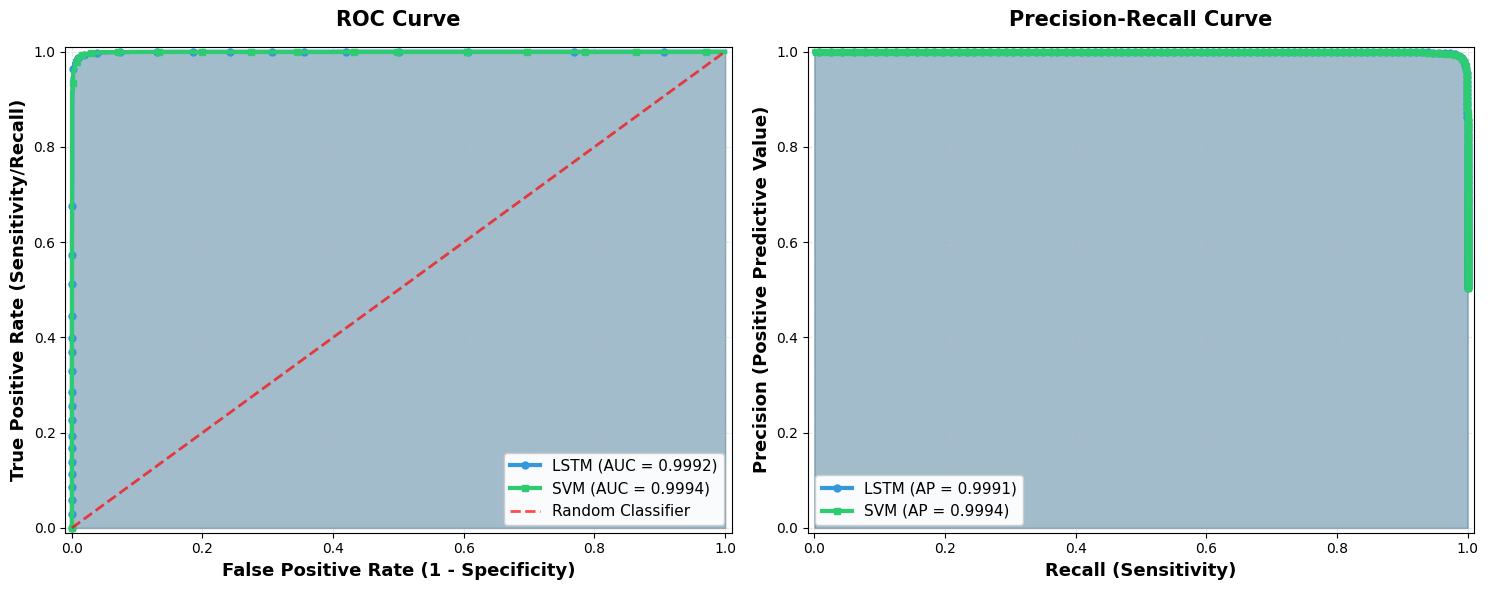

In [90]:
#ROC AND PR CURVES
fig1, axes = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
ax = axes[0]
ax.plot(lstm_fpr, lstm_tpr, color='#3498db', lw=3,
        label=f'LSTM (AUC = {lstm_roc_auc:.4f})', marker='o',
        markevery=50, markersize=5)
ax.plot(svm_fpr, svm_tpr, color='#2ecc71', lw=3,
        label=f'SVM (AUC = {svm_roc_auc:.4f})', marker='s',
        markevery=50, markersize=5)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--',
        label='Random Classifier', alpha=0.7)
ax.fill_between(lstm_fpr, lstm_tpr, alpha=0.2, color='blue')
ax.fill_between(svm_fpr, svm_tpr, alpha=0.2, color='green')
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=13, fontweight='bold')
ax.set_title('ROC Curve', fontsize=15, fontweight='bold', pad=15)
ax.legend(loc="lower right", fontsize=11, framealpha=0.95)
ax.grid(alpha=0.3, linestyle='--')


# Precision-Recall Curve
ax = axes[1]
ax.plot(lstm_recall_curve, lstm_precision_curve, color='#3498db', lw=3,
        label=f'LSTM (AP = {lstm_avg_precision:.4f})', marker='o',
        markevery=50, markersize=5)
ax.plot(svm_recall_curve, svm_precision_curve, color='#2ecc71', lw=3,
        label=f'SVM (AP = {svm_avg_precision:.4f})', marker='s',
        markevery=50, markersize=5)
ax.fill_between(lstm_recall_curve, lstm_precision_curve, alpha=0.2, color='blue')
ax.fill_between(svm_recall_curve, svm_precision_curve, alpha=0.2, color='green')
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])
ax.set_xlabel('Recall (Sensitivity)', fontsize=13, fontweight='bold')
ax.set_ylabel('Precision (Positive Predictive Value)', fontsize=13, fontweight='bold')
ax.set_title('Precision-Recall Curve', fontsize=15, fontweight='bold', pad=15)
ax.legend(loc="lower left", fontsize=11, framealpha=0.95)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('figure1_roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

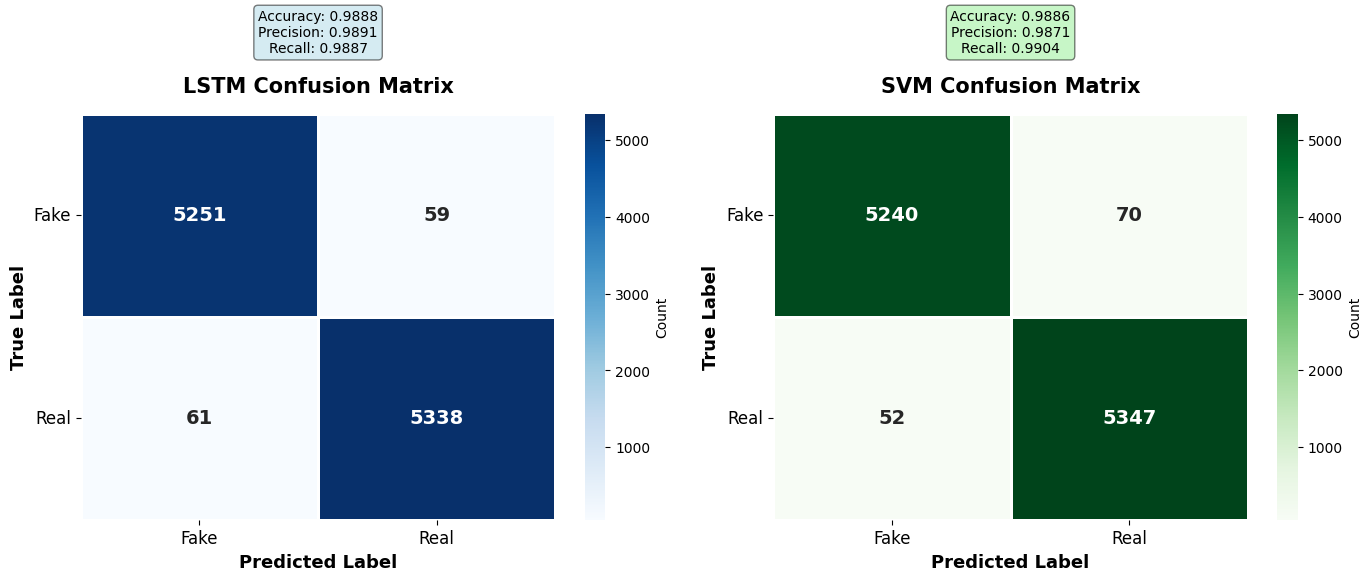

In [91]:
#CONFUSION MATRICES
fig2, axes = plt.subplots(1, 2, figsize=(14, 6))

# LSTM Confusion Matrix
ax = axes[0]
cm_lstm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', ax=ax,
            cbar_kws={'label': 'Count'}, annot_kws={'size': 14, 'weight': 'bold'},
            linewidths=2, linecolor='white')
ax.set_title('LSTM Confusion Matrix', fontsize=15, fontweight='bold', pad=15)
ax.set_ylabel('True Label', fontsize=13, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax.set_xticklabels(['Fake', 'Real'], fontsize=12)
ax.set_yticklabels(['Fake', 'Real'], fontsize=12, rotation=0)

# Add accuracy text
accuracy_text = f'Accuracy: {lstm_acc:.4f}\nPrecision: {lstm_prec:.4f}\nRecall: {lstm_rec:.4f}'
ax.text(1, -0.3, accuracy_text, fontsize=10, ha='center',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# SVM Confusion Matrix
ax = axes[1]
cm_svm = confusion_matrix(y_test_svm, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', ax=ax,
            cbar_kws={'label': 'Count'}, annot_kws={'size': 14, 'weight': 'bold'},
            linewidths=2, linecolor='white')
ax.set_title('SVM Confusion Matrix', fontsize=15, fontweight='bold', pad=15)
ax.set_ylabel('True Label', fontsize=13, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax.set_xticklabels(['Fake', 'Real'], fontsize=12)
ax.set_yticklabels(['Fake', 'Real'], fontsize=12, rotation=0)

# Add accuracy text
accuracy_text = f'Accuracy: {svm_acc:.4f}\nPrecision: {svm_prec:.4f}\nRecall: {svm_rec:.4f}'
ax.text(1, -0.3, accuracy_text, fontsize=10, ha='center',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.savefig('figure2_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

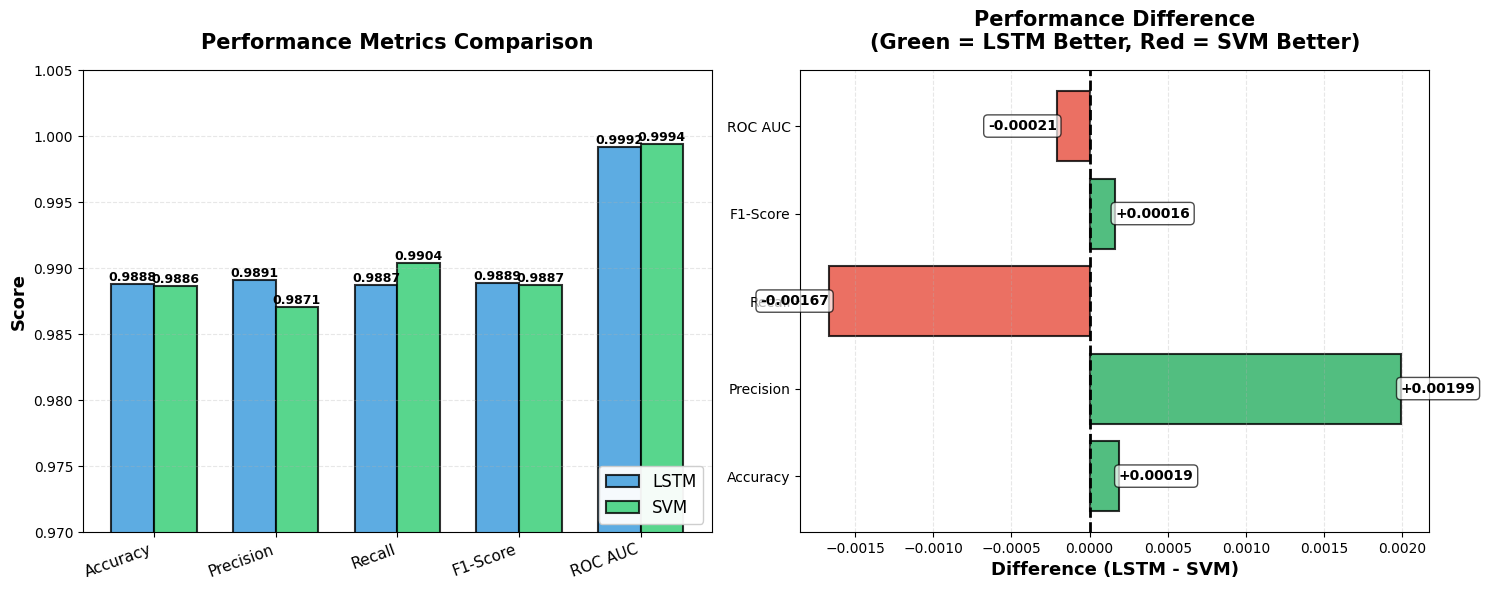

In [92]:
fig3, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar Chart Comparison
ax = axes[0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
x_pos = np.arange(len(metrics))
lstm_scores = [lstm_acc, lstm_prec, lstm_rec, lstm_f1, lstm_roc_auc]
svm_scores = [svm_acc, svm_prec, svm_rec, svm_f1, svm_roc_auc]

width = 0.35
bars1 = ax.bar(x_pos - width/2, lstm_scores, width, label='LSTM',
               alpha=0.8, color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x_pos + width/2, svm_scores, width, label='SVM',
               alpha=0.8, color='#2ecc71', edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom',
                fontsize=9, fontweight='bold')

ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Performance Metrics Comparison', fontsize=15, fontweight='bold', pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics, fontsize=11, rotation=20, ha='right')
ax.legend(fontsize=12, loc='lower right', framealpha=0.95)
ax.set_ylim([0.97, 1.005])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Difference Analysis
ax = axes[1]
diff_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
differences = [
    lstm_acc - svm_acc,
    lstm_prec - svm_prec,
    lstm_rec - svm_rec,
    lstm_f1 - svm_f1,
    lstm_roc_auc - svm_roc_auc
]
colors = ['#27ae60' if d > 0 else '#e74c3c' if d < 0 else '#95a5a6' for d in differences]
bars = ax.barh(diff_metrics, differences, color=colors, alpha=0.8,
               edgecolor='black', linewidth=1.5)

# Add value labels
for i, (bar, diff) in enumerate(zip(bars, differences)):
    ax.text(diff, i, f'{diff:+.5f}',
            ha='left' if diff > 0 else 'right',
            va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

ax.set_xlabel('Difference (LSTM - SVM)', fontsize=13, fontweight='bold')
ax.set_title('Performance Difference\n(Green = LSTM Better, Red = SVM Better)',
             fontsize=15, fontweight='bold', pad=15)
ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('figure3_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()